This notebook can be used to process data for the optint task.

It can also be used to replicate **Fig. S9**.

In [1]:
import numpy as np
import pandas as pd
import pickle
import scipy.sparse
from tqdm import tqdm

### saving samples of each perturbation into a .pkl file

In [ ]:
ctrl_cells = pd.read_csv("../data/controlscreen_observational_samples_reduced.csv")
genes = ctrl_cells['GENE'].to_numpy()

with open("../../data/pertub_dict.pkl", 'rb') as f:
	pertub_dict = pickle.load(f)

ctrl_cells.to_numpy()[:, 1:].astype(float)

np.save("../../data/samples+/ctrl.npy", ctrl_cells.to_numpy()[:,1:].astype(float))

all_ptb_cells = []
all_genes = []
header = []

count = 0
with open("../data/RNA_expression.csv") as csv_file:
	for row in csv_file:
		if count == 0:
			header = row.split(',')[1:]
			count += 1
		else:
			row = row.split(',')
			all_genes.append(row[0])
			all_ptb_cells.append(scipy.sparse.csr_matrix(np.array(row[1:], dtype=float)))
 
all_ptb_cells = scipy.sparse.vstack(all_ptb_cells)

ptb_cells_id = np.concatenate([pertub_dict['Control'][a] if a != '' else [] for a in pertub_dict['Control'].keys()])
ptb_cells_idx = [header.index(i) for i in ptb_cells_id]
genes_idx = [all_genes.index(i) for i in genes]

all_ptb_cells_reduced = all_ptb_cells.T[:, genes_idx]

selected_ptbs = []
selected_samples = {}
for a in pertub_dict['Control'].keys():
	if all(i in genes for i in a.split('_')):
		selected_ptbs.append(a)
	if any(i in genes for i in a.split('_')):
		key = '_'.join([i for i in a.split('_') if i in genes])
		if key in selected_samples.keys():
			selected_samples[key].append(a)
		else:
			selected_samples[key] = [a]

for a in tqdm(selected_ptbs):
	ptb_cells_idx = []
	for b in selected_samples[a]:
		ptb_cells_idx += [header.index(i) for i in pertub_dict['Control'][b]]
	subset = all_ptb_cells_reduced[ptb_cells_idx, :].toarray()
	np.save(f"../../data/samples+/ptb_{a}.npy", subset)

with open("../../data/ptb_list.pkl", 'wb') as file:
	pickle.dump(selected_ptbs, file)


### merging samples from considered perturbations

In [2]:
with open("../../data/gene_dict.pkl", 'rb') as f:
	gene_dict = pickle.load(f)

In [4]:
data = {}

In [5]:
import glob

for file in glob.glob("../../data/samples+/*npy"):
	f = file.split("/")[-1].split(".")[0]
	with open(file, 'rb') as file:
		data[f] = np.load(file)

In [48]:
mean = np.average(data['ctrl'], axis=1)

data_new = {}
for k in data.keys():
	if k == 'ctrl':
		data_new[k] = (np.zeros(36), data[k].shape[1], np.mean(data[k], axis=1), data[k])
	else:
		new_k = np.zeros(36)
		for g in k.split("_")[1:]:
			new_k[gene_dict[g]] = - mean[gene_dict[g]]
		data_new[k] = (new_k, data[k].shape[0], np.mean(data[k].T, axis=1), data[k].T)

with open("../../data/data+.pkl", 'wb') as file:
	pickle.dump(data_new, file)

### sample size of each perturbation

In [11]:
ptb_cells_nums = [len(pertub_dict['Control'][a]) for a in selected_ptbs]

In [12]:
sorted_selected_ptbs = sorted(selected_ptbs, key=lambda x: x.split('_').__len__())
sorted_ptb_cells_nums = []
for a in sorted_selected_ptbs:
	sorted_ptb_cells_nums.append(np.sum([len(pertub_dict['Control'][b]) for b in selected_samples[a]]))

In [14]:
int_cell_nums = {}

for ptb, cnum in zip(sorted_selected_ptbs, sorted_ptb_cells_nums):
	l = len(ptb.split('_'))
	try:
		int_cell_nums[l].append(cnum)
	except:
		int_cell_nums[l] = [cnum]

sorted_cell_num = []
for l in sorted(int_cell_nums.keys()):
	sorted_cell_num += list(sorted(int_cell_nums[l], reverse=True))


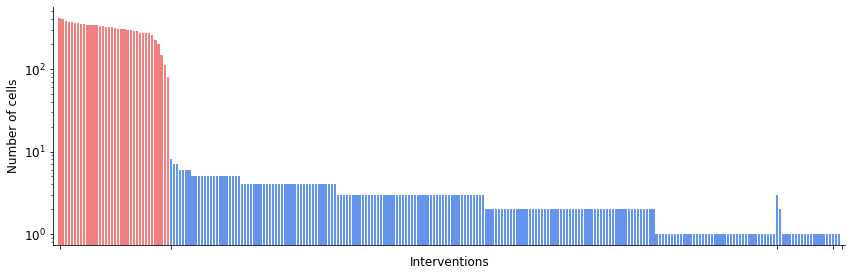

In [32]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
plt.rcParams.update({'font.size': 12})
plt.yscale('log')
plt.bar(np.arange(len(sorted_cell_num))+1, sorted_cell_num, color=['lightcoral']*len(int_cell_nums[1])+['cornflowerblue']*(len(sorted_cell_num)-len(int_cell_nums[1])), width=0.75, alpha=1)

tick = [1]
tick_label = ['']
for l in sorted(int_cell_nums.keys()):
	tick.append(tick[-1]+len(int_cell_nums[l]))
	tick_label.append('')
plt.xticks(tick, rotation=90, labels=tick_label);
plt.xlim(-1, 255)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.ylabel('Number of cells')
plt.xlabel('Interventions')
plt.tight_layout()
# plt.savefig('../../figures/bar_samples.pdf')

In [78]:
cell_nums = {}

for ptb, cnum in zip(sorted_selected_ptbs, sorted_ptb_cells_nums):
	l = len(ptb.split('_'))
	try:
		cell_nums[l] += cnum
	except:
		cell_nums[l] = cnum


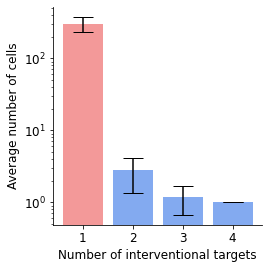

In [91]:
fig, ax = plt.subplots(1,1,figsize=(3.9,3.9))
plt.rcParams.update({'font.size': 12})
plt.yscale('log')
plt.bar(int_cell_nums.keys(), [np.average(l) for l in int_cell_nums.values()], yerr=[np.std(l) for l in int_cell_nums.values()], capsize=10, color=['lightcoral']+['cornflowerblue']*3, alpha=0.8)
plt.xticks([1,2,3,4])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlabel('Number of interventional targets')
plt.ylabel('Average number of cells')
plt.tight_layout()
plt.savefig('../../figures/bar_avgsample.pdf')